# Qiskit Workshop: Computing molecular energy states with Qiskit Nature



In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
# Import other needed libraries
import numpy as np
import matplotlib.pyplot as plt

---

## Introduction

**Goal**: Solve non-relativistic time independent Schroedinger equation,

<center>
    $\mathcal{H}_{\text{el}} |\Psi_{n}\rangle = E_{n} |\Psi_{n}\rangle$
</center>

to find the energies $E_n$. The ground state energy, $E_0$, given by:

<center>
    $E_0 = \frac{\langle \Psi_0 | H_{\text{el}} | \Psi_0 \rangle}{\langle \Psi_0 | \Psi_0 \rangle}$
</center>

**Solution**: Use eigenvalue solver to find energies $E_n$.

---

## Qiskit Nature features
- Interfaces to common classical chemistry libraries/programs ("drivers")
    - Gaussian
    - PSI4
    - PyQuante
    - PYSCF
- Functions to map various operators to qubit operators
- Common ansatz preparation circuits for variational solvers

---

## Setting up the problem

### Step 1: Create molecule and the driver

In [3]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

# Create molecule
molecule = MoleculeInfo(['H', 'H'], [(0., 0., 0.), (0., 0., 0.735)],
                        charge=0, 
                        multiplicity=1)

# Instantiate driver
driver = PySCFDriver.from_molecule(molecule = molecule, basis='sto3g')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


<br>

*Step 2a:* Get the `ElectronicStructureProblem` object by running the driver and compute Second quantization operator

In [4]:
es_problem = driver.run()
second_q_op = es_problem.hamiltonian.second_q_op()
print(second_q_op)

Fermionic Operator
number spin orbitals=4, number terms=36
  0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211565 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211556 * ( +_0 +_1 -_0 -_1 )
+ 0.33229086512764827 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.09046559989211565 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211556 * ( +_0 +_3 -_2 -_1 )
+ 0.33229086512764827 * ( +_0 +_3 -_3 -_0 )
+ 0.33229086512764816 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211574 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211564 * ( +_1 +_1 -_0 -_0 )
+ 0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ 0.33229086512764816 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211574 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211564 * ( +_1 +_3 -_2 -_0 )
+ 0.34928686136600906 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.09046559989211565 * ( +_2 +_0 -_1 -_3 )
+ 0.09046559989211556 * ( +_2 +_1 -_0 -_3 )
+ 0.33229086512764827 * ( +_2 +_1 -_1 -_2 )
+ 0.33785507740175813 * ( +_2 +_2 -_2 -_2 )
+ 0.0904655998921

<br>

*Step 2b:* Map to qubit spin operators

Available mappings:
- Jordan-Wigner
- Parity
- Bravyi-Kitaev

In [5]:
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter

jw_qubit_converter = QubitConverter(mapper=JordanWignerMapper())
jw_qubit_op = jw_qubit_converter.convert(second_q_op)
print(jw_qubit_op)

-0.8105479805373283 * IIII
+ 0.17218393261915543 * IIIZ
- 0.2257534922240237 * IIZI
+ 0.12091263261776633 * IIZZ
+ 0.17218393261915543 * IZII
+ 0.16892753870087907 * IZIZ
+ 0.045232799946057826 * YYYY
+ 0.045232799946057826 * XXYY
+ 0.045232799946057826 * YYXX
+ 0.045232799946057826 * XXXX
- 0.22575349222402363 * ZIII
+ 0.1661454325638241 * ZIIZ
+ 0.16614543256382408 * IZZI
+ 0.1746434306830045 * ZIZI
+ 0.12091263261776633 * ZZII


In [6]:
from qiskit_nature.second_q.mappers import ParityMapper

pr_qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
pr_qubit_op = pr_qubit_converter.convert(second_q_op, num_particles=es_problem.num_particles)
print(pr_qubit_op)

-1.0523732457728605 * II
+ 0.39793742484317896 * IZ
- 0.39793742484317896 * ZI
- 0.01128010425623538 * ZZ
+ 0.18093119978423122 * XX


---

## Solve for ground state energy using VQE

<img src=https://qiskit.org/documentation/nature/_images/vqe.png width=1000px>

### Step 1: Create VQE solver

#### Create/Instatiate a parameterized ansatz circuit, then pass to `VQE` class

Available ansatz circuits / variational forms:
- `TwoLocal`
- `EfficientSU2`
- `UCC` (Unitary coupled cluster)

In [7]:
n = jw_qubit_op.num_qubits
#n = pr_qubit_op.num_qubits

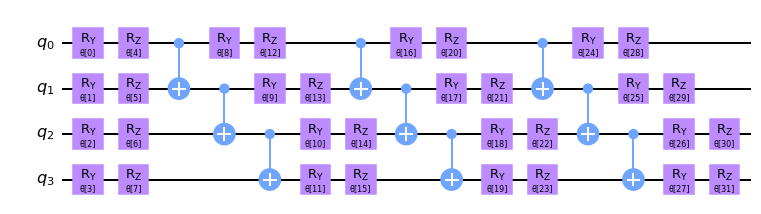

In [9]:
from qiskit.circuit.library import EfficientSU2

su2_circ = EfficientSU2(num_qubits=n, entanglement='linear')
su2_circ.decompose().draw()

<br> 

Now, create the VQE solver with the desired ansatz

In [11]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SLSQP

vqe_solver = VQE(Estimator(), su2_circ, SLSQP())

<br>

### Step 2: Run ground state solver

In [13]:
# Choose your converter!

# JW mapping (uses 4 qubits)
qubit_converter = jw_qubit_converter



<br> 

Using the `VQE` class with `EfficientSU2`

In [14]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

# Using the VQE class with EfficientSU2 ansatz
su2_gsc = GroundStateEigensolver(qubit_converter, vqe_solver)
result = su2_gsc.solve(es_problem)

print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857246283278
  - computed part:      -1.857246283278
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137277288829
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38881206]
    - computed part:      [0.0  0.0  1.38881206]
  > Dipole moment (a.u.): [0.0  0.0  0.00013664]  Total: 0.00013664
                 (debye): [0.0  0.0  0.0003473]  Total: 0.0003473
 


<br>

Check against classical solver

In [16]:
# Check against classical solver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

np_gsc = GroundStateEigensolver(qubit_converter, numpy_solver)
np_result = np_gsc.solve(es_problem)

print(np_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 
